In [1]:
import keras.backend as K
from keras.layers import Input, Add, Dense, Activation, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.constraints import max_norm
from keras.layers.noise import GaussianNoise
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import matplotlib.pyplot as plt
import config
import importlib
import os
import numpy as np
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = C.nb_classes

X_train = np.expand_dims(x_train,axis=3)
X_train = np.expand_dims(X_train,axis=4)
X_test = np.expand_dims(x_test,axis=3)
X_test = np.expand_dims(X_test,axis=4)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [2]:
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [57]:
C = config.Config()
dims = C.dims
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
#x = Dropout(0.2)(voi_img)
#x = GaussianNoise(1)(x)
#x = ZeroPadding3D(padding=(3,3,2))(voi_img)
#x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu', kernel_regularizer=l2(.01))(x)
x = Conv3D(filters=32, kernel_size=(3,3,1), activation='relu')(voi_img)
x = Conv3D(filters=64, kernel_size=(3,3,1), activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dropout(0.2)(x)
intermed = MaxPooling3D((2, 2, 2))(x)
x = Flatten()(intermed)
x = Dense(128, activation='relu')(x)#, kernel_initializer='normal', kernel_regularizer=l1(.01), kernel_constraint=max_norm(3.))(x)
x = Dropout(0.5)(x)
pred_class = Dense(C.nb_classes, activation='softmax')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [58]:
optim = Adam(lr=0.1)#, decay=0.001)
early_stopping = EarlyStopping(min_delta=0.01, patience=5)

model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 20, 10, 2)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 18, 18, 10, 32)    608       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 16, 16, 10, 64)    18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 10, 64)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 8, 5, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2621568   
__________

In [59]:
model2 = Model(voi_img, intermed)

for l in range(2,len(model2.layers)):
    model2.layers[l].set_weights(model.layers[l].get_weights())

X_train = []
Y_train = []

for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    Y_train.append([1,0])
for _ in range(10):
    X_train.append(np.ones(dims + [C.nb_channels]))
    X_train[-1][5:15,5:15,5:7,0] = 2
    Y_train.append([0,1])
    
X_train = np.array(X_train) # X[:total_size//2]
#X_val = np.array(X_test)
Y_train = np.array(Y_train) # Y[:total_size//2]
#Y_val = np.array(Y_test)

In [51]:
data_dict = {}
max_samples = 10000
base_dir = "..\\liver-mr-processor\\train_imgs\\"

least_in_one_class = max_samples

for class_name in os.listdir(base_dir):
    x = np.empty((max_samples, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    for index, img_fn in enumerate(os.listdir(base_dir+class_name)):
        x[index] = np.load(base_dir+class_name+"\\"+img_fn)
        z.append(img_fn)
    
    least_in_one_class = min(index, least_in_one_class)
    x.resize((index, dims[0], dims[1], dims[2], C.nb_channels))
    max_samples = index
    data_dict[class_name] = [x,np.array(z)]

In [106]:
train_size = least_in_one_class*3//4 * C.nb_classes
X_train = []
Y_train = []
Z_train = []
X_test = []
Y_test = []
Z_test = []
train_frac = 0.75
cls_mapping = []

for cls_num, cls in enumerate(data_dict):
    order = np.random.permutation(list(range(max_samples)))
    X_train = X_train + list(data_dict[cls][0][order[:round(least_in_one_class*train_frac)]])
    X_test = X_test + list(data_dict[cls][0][order[round(least_in_one_class*train_frac):]])
    Z_train = Z_train + list(data_dict[cls][1][order[:round(least_in_one_class*train_frac)]])
    Z_test = Z_test + list(data_dict[cls][1][order[round(least_in_one_class*train_frac):]])
    Y_train = Y_train + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * (round(least_in_one_class*train_frac))
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (max_samples - round(least_in_one_class*train_frac))
        
    cls_mapping.append(cls)

In [55]:
X_train = np.array(X_train) # X[:total_size//2]
X_val = np.array(X_test)
X_train /= 255
X_val /= 255
#X_val = X[total_size//2:total_size*3//4]
#X_test = X[total_size*3//4:]
Y_train = np.array(Y_train)
Y_val = np.array(Y_test)
Z_train = np.array(Z_train)
Z_val = np.array(Z_test)
#Y_val = Y[total_size//2:total_size*3//4]
#Y_test = Y[total_size*3//4:]

In [42]:
#X = np.array([z for z in x])
#Y = np.array(y)
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

#total_size = X.shape[0]

#order = np.random.permutation(list(range(total_size)))
#X = X[order]
#Y = Y[order]

def train_generator(X, Y):
    while True:
        for i in range(len(X)):
            yield np.expand_dims(X[i], axis=0), np.expand_dims(Y[i], axis=0)

num_epochs = 10
epoch_length = 100
best_loss = np.Inf
losses = np.zeros(epoch_length)
acc = np.zeros(epoch_length)

data_gen_train = train_generator(X_train, Y_train)
for epoch_num in range(num_epochs):
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
    iter_num = 0
    
    while True:
        X, Y = next(data_gen_train)
        losses[iter_num], acc[iter_num] = model.train_on_batch(X, Y)

        iter_num += 1
        if iter_num == epoch_length:
            curr_loss = np.mean(losses)
            curr_acc = np.mean(acc)
            print("Mean Loss:", curr_loss, "// Mean Accuracy:", curr_acc)

            if curr_loss < best_loss:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model.save_weights(C.model_path)
            break

In [60]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=200, validation_data=(X_val, Y_val)) #callbacks=[early_stopping]

Train on 358 samples, validate on 120 samples
Epoch 1/200
358/358 [==============================] - 0s - loss: 0.8896 - acc: 0.4972 - val_loss: 0.7563 - val_acc: 0.5000
Epoch 2/200
358/358 [==============================] - 0s - loss: 0.7794 - acc: 0.5000 - val_loss: 0.6971 - val_acc: 0.5000
Epoch 3/200
358/358 [==============================] - 0s - loss: 0.6951 - acc: 0.5279 - val_loss: 0.6832 - val_acc: 0.8917
Epoch 4/200
358/358 [==============================] - 0s - loss: 0.6794 - acc: 0.5978 - val_loss: 0.6729 - val_acc: 0.7833
Epoch 5/200
358/358 [==============================] - 0s - loss: 0.6641 - acc: 0.6313 - val_loss: 0.6519 - val_acc: 0.6333
Epoch 6/200
358/358 [==============================] - 0s - loss: 0.6424 - acc: 0.6117 - val_loss: 0.6371 - val_acc: 0.7583
Epoch 7/200
358/358 [==============================] - 0s - loss: 0.6112 - acc: 0.6341 - val_loss: 0.6031 - val_acc: 0.7500
Epoch 8/200
358/358 [==============================] - 0s - loss: 0.5701 - acc: 0.7318

358/358 [==============================] - 0s - loss: 0.0373 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9917
Epoch 67/200
358/358 [==============================] - 0s - loss: 0.0282 - acc: 0.9944 - val_loss: 0.0357 - val_acc: 0.9750
Epoch 68/200
358/358 [==============================] - 0s - loss: 0.0202 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9667
Epoch 69/200
358/358 [==============================] - 0s - loss: 0.0183 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9833
Epoch 70/200
358/358 [==============================] - 0s - loss: 0.0201 - acc: 0.9972 - val_loss: 0.0321 - val_acc: 0.9833
Epoch 71/200
358/358 [==============================] - 0s - loss: 0.0218 - acc: 0.9972 - val_loss: 0.0382 - val_acc: 0.9833
Epoch 72/200
358/358 [==============================] - 0s - loss: 0.0306 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9750
Epoch 73/200
358/358 [==============================] - 0s - loss: 0.0119 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9750
Epoch 74/200


358/358 [==============================] - 0s - loss: 0.0211 - acc: 1.0000 - val_loss: 0.0790 - val_acc: 0.9750
Epoch 132/200
358/358 [==============================] - 0s - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0719 - val_acc: 0.9750
Epoch 133/200
358/358 [==============================] - 0s - loss: 0.0285 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9917
Epoch 134/200
358/358 [==============================] - 0s - loss: 0.0184 - acc: 0.9972 - val_loss: 0.0266 - val_acc: 0.9833
Epoch 135/200
358/358 [==============================] - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0305 - val_acc: 0.9833
Epoch 136/200
358/358 [==============================] - 0s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9917
Epoch 137/200
358/358 [==============================] - 0s - loss: 0.0165 - acc: 0.9944 - val_loss: 0.0822 - val_acc: 0.9833
Epoch 138/200
358/358 [==============================] - 0s - loss: 0.0137 - acc: 0.9972 - val_loss: 0.0258 - val_acc: 0.9833
Epoch 

358/358 [==============================] - 0s - loss: 0.0093 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9750
Epoch 197/200
358/358 [==============================] - 0s - loss: 0.0166 - acc: 0.9972 - val_loss: 0.0524 - val_acc: 0.9833
Epoch 198/200
358/358 [==============================] - 0s - loss: 0.0154 - acc: 0.9944 - val_loss: 0.0374 - val_acc: 0.9917
Epoch 199/200
358/358 [==============================] - 0s - loss: 0.0113 - acc: 0.9944 - val_loss: 0.0192 - val_acc: 0.9917
Epoch 200/200
358/358 [==============================] - 0s - loss: 0.0164 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9833


In [159]:
activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

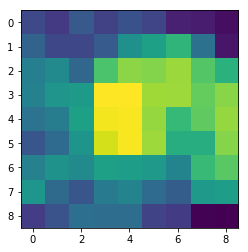

In [166]:
plt.imshow(activ[20][:,:,3,5])

In [162]:
activ[0][5,5,2,:]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  121.71251678,   53.23372269,    0.        ,
          0.        ,   24.43340492,    0.        ,    0.        ,
          0.        ,    0.        ,    7.88301706,    0.        ], dtype=float32)

In [113]:
Z_val[::30]

array(['12296182_23.npy', '13028374_2.npy', 'E104657225_14.npy',
       '12972894_6.npy'],
      dtype='<U17')

In [130]:
import operator
print("Ground truth:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_val[::30])
print("Predictions:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% confidence)" % (max(x)*100) for x in Y_])

Ground truth: ['cyst', 'cyst', 'hcc', 'hcc']
Predictions: ['cyst (99.99999% confidence)', 'cyst (100.00000% confidence)', 'hcc (99.99965% confidence)', 'hcc (99.99998% confidence)']


In [132]:
import pandas as pd
voi_df = pd.read_csv('vois.csv')

FileNotFoundError: File b'vois.csv' does not exist

In [ ]:
img_fn = "12296182.npy"
img = np.load("full_imgs\\"+img_fn)
plt.imshow(np.transpose(img[:,::-1,(df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')

In [20]:
Y_[-1]

array([  2.78843247e-04,   9.99721110e-01], dtype=float32)

In [19]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6875

In [122]:
sum(Y_)/len(Y_)

array([ 0.], dtype=float32)

In [121]:
Y_ = model.predict(X_test)

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

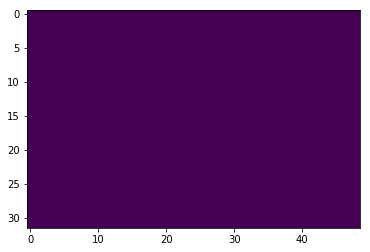

In [140]:
plt.imshow(X[0,:,:,5,0])

In [108]:
Y.shape

(1650, 2)

In [73]:
hist.history

{'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'loss': [1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07],
 'val_acc': [0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142],
 'val_loss': [10.682890466896884,
  10.682890466896884,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052]}